In [1]:
import xarray as xr
import math
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch
import gpytorch
import matplotlib.pyplot as plt
import cf_units
import datetime
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
sea_level_dataset = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')
sea_level_dataarray = sea_level_dataset['sea_level']
#yt = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')['lat'].data
#xt = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')['long'].data


In [4]:
interval1 = sea_level_dataarray.sel(xt_ocean= -150, yt_ocean= 20, method="nearest").isel(time = slice(0,3000))

timeint1 = interval1['time']
timearray1int = np.array(timeint1)
timeint111 = cf_units.date2num(timearray1int,'days since 0185-01-01 12:00:00' , calendar='julian')
print(timeint111)



timeint111 = timeint111.reshape(-1,1)


# #need to convert to nparray to then become a torch tensor
interval11 = np.array(interval1)
interval11 = interval11.reshape(-1,1)
print(interval11.shape)



[0.000e+00 1.000e+00 2.000e+00 ... 2.997e+03 2.998e+03 2.999e+03]
(3000, 1)


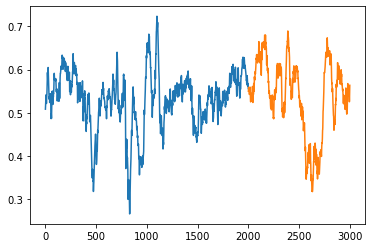

In [5]:
train_x = timeint111[0:2000]
train_y = interval11[0:2000]


test_x = timeint111[2000:3000]
test_y = interval11[2000:3000]
plt.plot(train_x, train_y)
plt.plot(test_x, test_y)

In [10]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

train_scaler = MinMaxScaler()
scaled_train = train_scaler.fit_transform(train_y)
test_scaler = MinMaxScaler()
scaled_test = test_scaler.fit_transform(test_y)


seq_length = 50
train_x_windows, train_y_windows = sliding_windows(scaled_train, seq_length)
test_x_windows, test_y_windows = sliding_windows(scaled_test, seq_length)

train_x_windows, train_y_windows = torch.Tensor(train_x_windows), torch.Tensor(train_y_windows)
test_x_windows, test_y_windows = torch.Tensor(test_x_windows), torch.Tensor(test_y_windows)

In [11]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [12]:
num_epochs = 2000
learning_rate = 0.01


input_size = 1
hidden_size = 4
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(train_x_windows)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, train_y_windows)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04315
Epoch: 100, loss: 0.00119
Epoch: 200, loss: 0.00056
Epoch: 300, loss: 0.00042
Epoch: 400, loss: 0.00031
Epoch: 500, loss: 0.00024
Epoch: 600, loss: 0.00020
Epoch: 700, loss: 0.00017
Epoch: 800, loss: 0.00015
Epoch: 900, loss: 0.00015
Epoch: 1000, loss: 0.00015
Epoch: 1100, loss: 0.00015
Epoch: 1200, loss: 0.00015
Epoch: 1300, loss: 0.00014
Epoch: 1400, loss: 0.00014
Epoch: 1500, loss: 0.00014
Epoch: 1600, loss: 0.00014
Epoch: 1700, loss: 0.00014
Epoch: 1800, loss: 0.00014
Epoch: 1900, loss: 0.00014


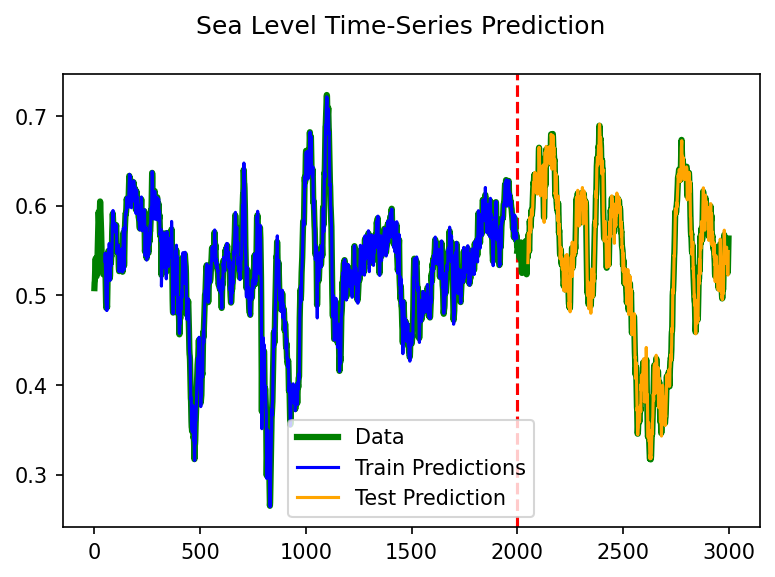

In [14]:
lstm.eval()
train_preds = lstm(train_x_windows)
# pred_xs = 
test_preds = lstm(test_x_windows)

#data_predict = train_predict.data.numpy()
#dataY_plot = dataY.data.numpy()

train_preds = train_scaler.inverse_transform(train_preds.detach().numpy())
test_preds = test_scaler.inverse_transform(test_preds.detach().numpy())

plt.figure(dpi=150)
plt.axvline(x=len(train_x), c='r', linestyle='--')

plt.plot(train_x.astype(int), train_y, c='g', label="Data", linewidth=3 )
plt.plot(train_x.astype(int)[seq_length:-1],  train_preds, c='b', label="Train Predictions")

plt.plot(test_x.astype(int), test_y, c='g', linewidth=3)
plt.plot(test_x.astype(int)[seq_length:-1],  test_preds, c='orange', label="Test Prediction")
plt.legend()

plt.suptitle('Sea Level Time-Series Prediction')
plt.show()